# Recurrent Neural Networks

## Import module

In [82]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [83]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, GRU

In [84]:
df = pd.read_csv('../data/cansim-0800020-eng-6674700030567901031.csv',
                 skiprows=6, skipfooter=9,
                 engine='python')
df.head()

,Adjustments,Unadjusted,Seasonally adjusted
0,Jan-1991,12588862,15026890
1,Feb-1991,12154321,15304585
2,Mar-1991,14337072,15413591
3,Apr-1991,15108570,15293409
4,May-1991,17225734,15676083


In [85]:
from pandas.tseries.offsets import MonthEnd

In [86]:
# Đổi string sang date *** Rất quan trọng khi làm RNN!!!!
df['Adjustments'] = pd.to_datetime(df['Adjustments']) + MonthEnd(1)
df = df.set_index('Adjustments')
df.head()

,Unadjusted,Seasonally adjusted
Adjustments,,
1991-01-31,12588862,15026890
1991-02-28,12154321,15304585
1991-03-31,14337072,15413591
1991-04-30,15108570,15293409
1991-05-31,17225734,15676083


<AxesSubplot:xlabel='Adjustments'>

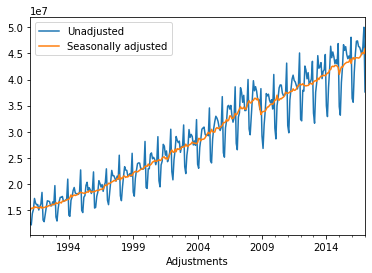

In [87]:
df.plot()

In [88]:
split_date = pd.Timestamp('01-01-2011')

In [89]:
train = df.loc[:split_date, ['Unadjusted']]
test = df.loc[split_date:, ['Unadjusted']]

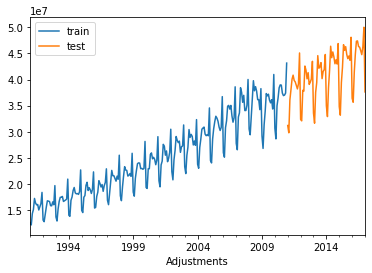

In [90]:
ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test'])

## Scaling, tách train-test

In [91]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()

train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

In [92]:
train_sc[:4]

array([[0.01402033],
       [0.        ],
       [0.0704258 ],
       [0.09531795]])

In [93]:
X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

In [94]:
early_stop = EarlyStopping(monitor='loss', patience=3, verbose=1)

In [95]:
train_sc.shape

(240, 1)

In [96]:
train_sc_df = pd.DataFrame(train_sc, columns=['Scaled'], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Scaled'], index=test.index)
train_sc_df.head()

,Scaled
Adjustments,
1991-01-31,0.014020
1991-02-28,0.000000
1991-03-31,0.070426
1991-04-30,0.095318
1991-05-31,0.163628


## Tạo các rolling window có kích thước 12 tháng

In [97]:
for s in range(1, 13):
    train_sc_df['shift_{}'.format(s)] = train_sc_df['Scaled'].shift(s)
    test_sc_df['shift_{}'.format(s)] = test_sc_df['Scaled'].shift(s)

In [98]:
train_sc_df.head(13)

,Scaled,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12
Adjustments,,,,,,,,,,,,,
1991-01-31,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-02-28,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-03-31,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-04-30,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-05-31,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-06-30,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-07-31,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN
1991-08-31,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN
1991-09-30,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN


In [99]:
X_train = train_sc_df.dropna().drop('Scaled', axis=1)
y_train = train_sc_df.dropna()[['Scaled']]

X_test = test_sc_df.dropna().drop('Scaled', axis=1)
y_test = test_sc_df.dropna()[['Scaled']]

In [100]:
X_train.head()

,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12
Adjustments,,,,,,,,,,,,
1992-01-31,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020
1992-02-29,0.030027,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000
1992-03-31,0.019993,0.030027,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426
1992-04-30,0.065964,0.019993,0.030027,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318
1992-05-31,0.109831,0.065964,0.019993,0.030027,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628


In [101]:
X_train.shape

(228, 12)

In [102]:
X_train = X_train.values
X_test= X_test.values

y_train = y_train.values
y_test = y_test.values

In [103]:
X_train_t = X_train.reshape(X_train.shape[0], 1, 12)
X_test_t = X_test.reshape(X_test.shape[0], 1, 12)

In [104]:
X_train_t.shape

(228, 1, 12)

### Tạo model RNN

In [110]:
K.clear_session()
model = Sequential()
# Thêm lớp LSTM
model.add(LSTM(6, input_shape=(1, 12)))
# Thêm lớp DNN đầu ra
model.add(Dense(1))
# Thiết lập thông số
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 6)                 456       
_________________________________________________________________
dense (Dense)                (None, 1)                 7         
Total params: 463
Trainable params: 463
Non-trainable params: 0
_________________________________________________________________


In [111]:
model.fit(X_train_t, y_train, epochs=100,
          batch_size=1, verbose=1, callbacks=[early_stop])

Epoch 1/100
228/228 [==============================] - 2s 5ms/step - loss: 0.0167
Epoch 2/100
228/228 [==============================] - 1s 5ms/step - loss: 0.0071
Epoch 3/100
228/228 [==============================] - 1s 5ms/step - loss: 0.0063
Epoch 4/100
228/228 [==============================] - 1s 5ms/step - loss: 0.0056
Epoch 5/100
228/228 [==============================] - 1s 5ms/step - loss: 0.0051
Epoch 6/100
228/228 [==============================] - 1s 5ms/step - loss: 0.0045
Epoch 7/100
228/228 [==============================] - 1s 5ms/step - loss: 0.0039
Epoch 8/100
228/228 [==============================] - 1s 6ms/step - loss: 0.0034
Epoch 9/100
228/228 [==============================] - 1s 5ms/step - loss: 0.0031
Epoch 10/100
228/228 [==============================] - 1s 5ms/step - loss: 0.0027
Epoch 11/100
228/228 [==============================] - 1s 5ms/step - loss: 0.0025
Epoch 12/100
228/228 [==============================] - 1s 5ms/step - loss: 0.0022
Epoch 13/100


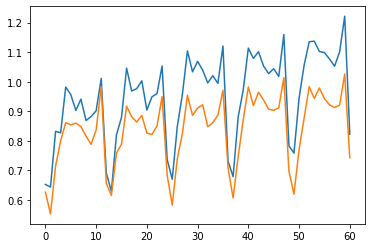

In [112]:
y_pred = model.predict(X_test_t)
plt.plot(y_test)
plt.plot(y_pred)

In [113]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred, squared=False)

0.11978795447315932

## Bài tập
Tinh chỉnh các thông số của mạng trên rồi xem sự thay đổi, sử dụng GRU thay cho LSTM

Thử sức với bộ dữ liệu giá cổ phiếu của Google